In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%run 1_preprocessing_data.ipynb

94 5 40
📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
        volume.sales        price
count    3256.000000  3256.000000
mean    40150.619340     2.022834
std     56176.374822     0.785525
min       452.360000     0.375449
25%      6606.907500     1.450135
50%     17814.810000     2.002405
75%     53415.565000     2.591298
max    539900.600000     4.036102


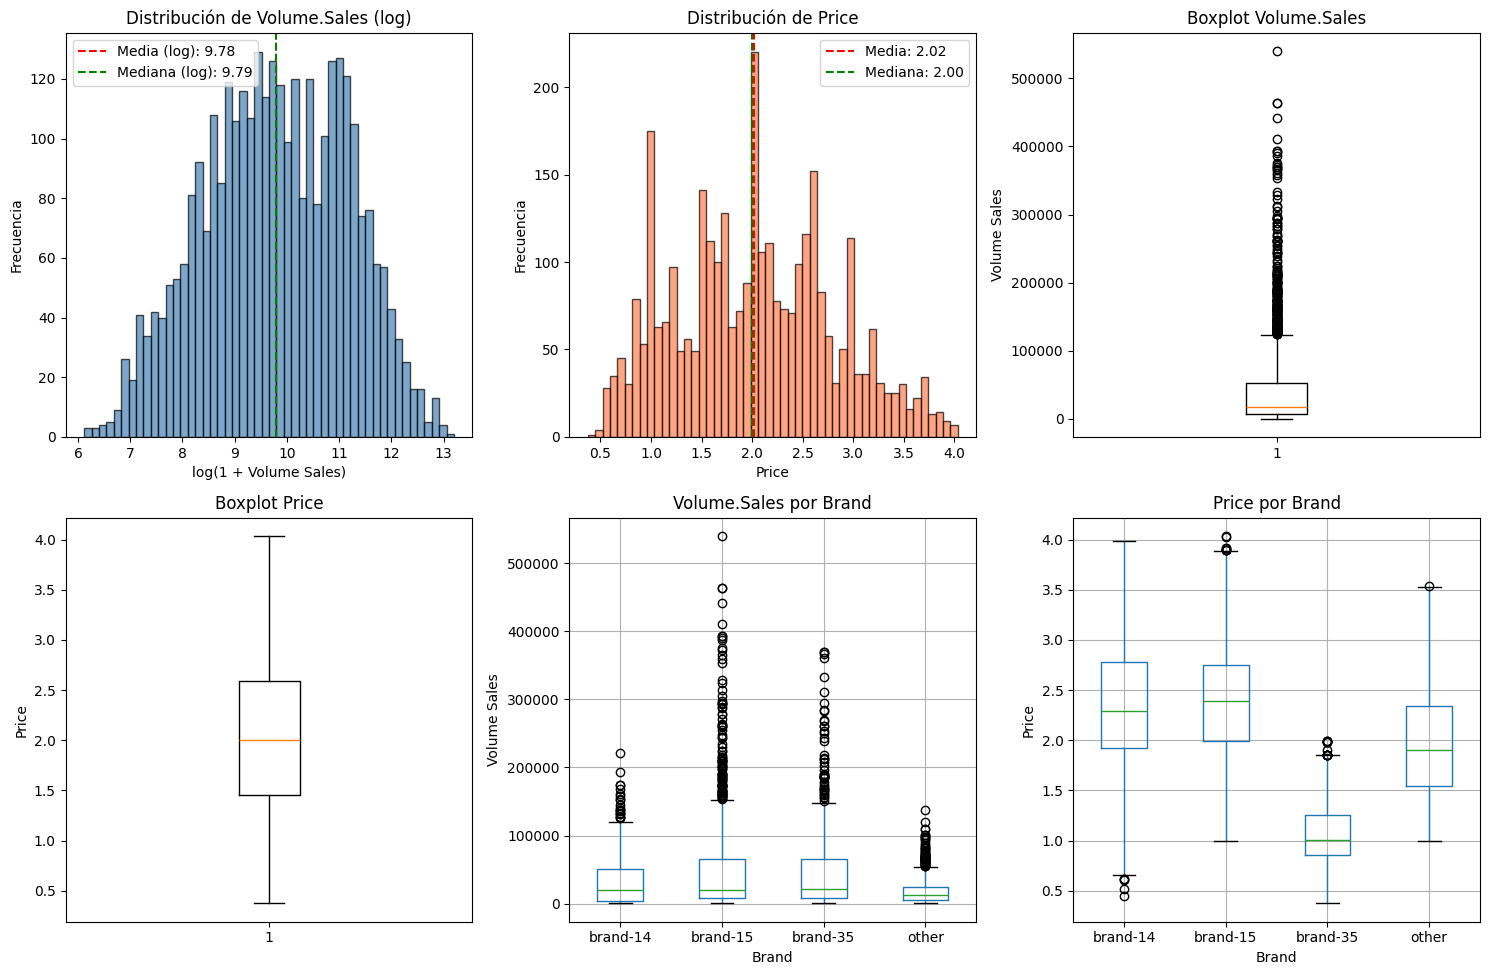


📊 DISTRIBUCIÓN POR CATEGORÍAS


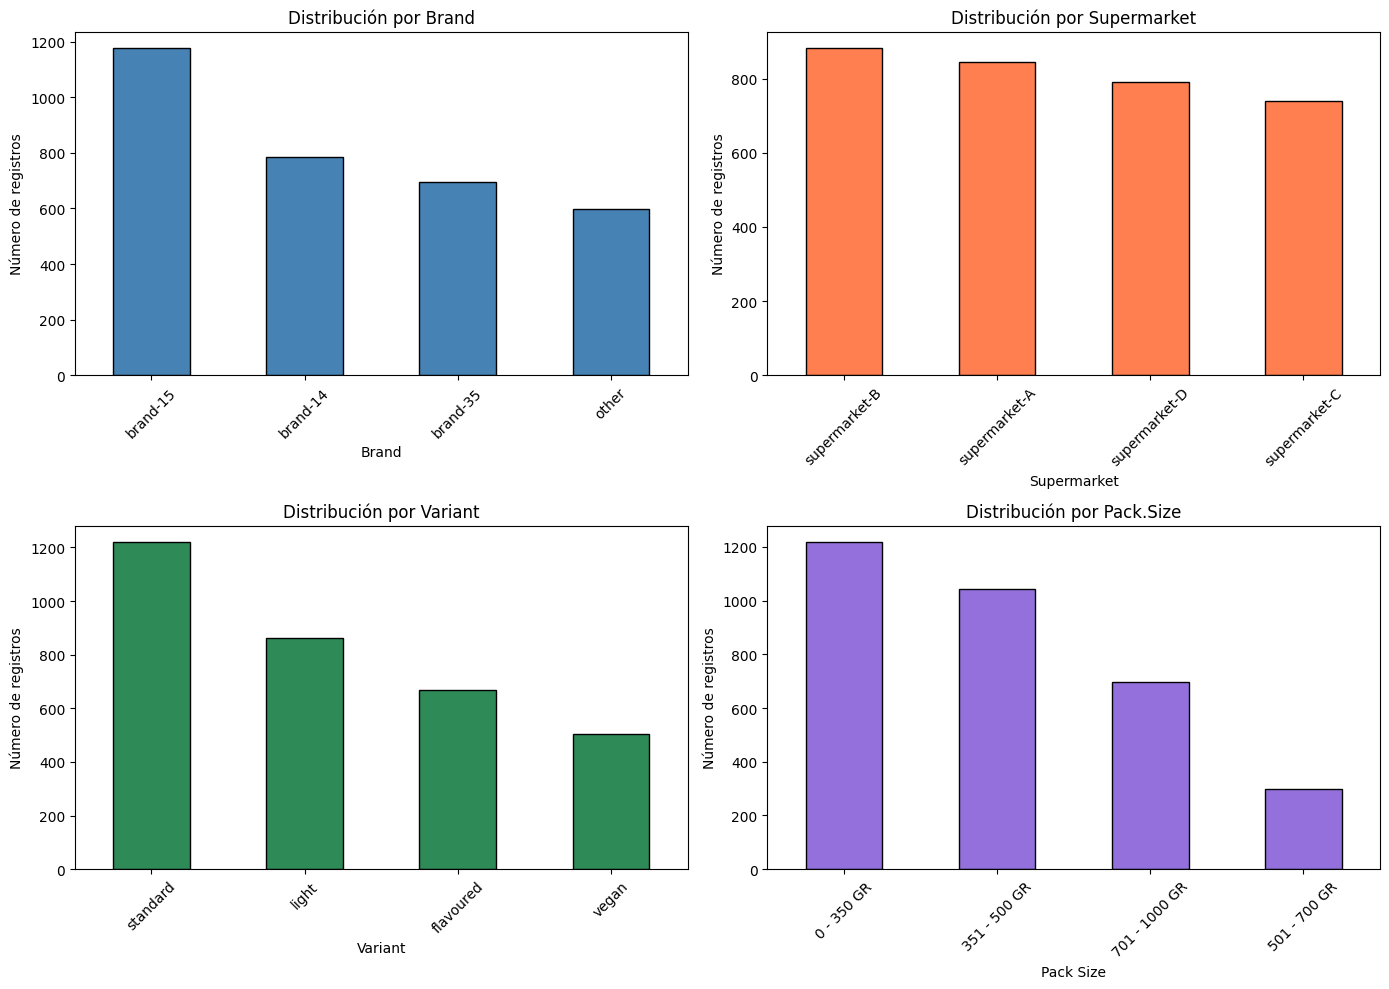


📊 CORRELACIÓN: VOLUME.SALES vs PRICE
Correlación de Pearson: 0.0398


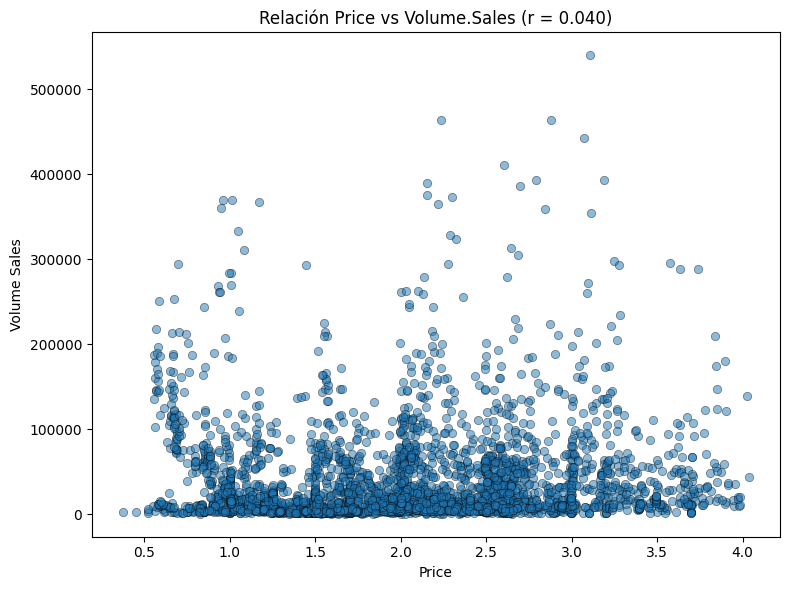

In [3]:
(
    data,
    filter_data,
    train_data,
    test_data,
    _,  # y_train_boxcox (no lo usamos)
    _,  # y_test_boxcox (no lo usamos)
    _,  # boxcox_transformation_info (no lo usamos)
) = run_preprocessing(ARIMA_model=True)

# Usamos los datos en escala original (sin transformación logarítmica ni Box-Cox)
y_train = train_data["volume.sales"].values
y_test = test_data["volume.sales"].values


ARIMA

## Determinación de los parámetros d y D

Para un modelo SARIMA(p,d,q)(P,D,Q)[m]:
- **d**: Orden de diferenciación regular (para eliminar tendencia)
- **D**: Orden de diferenciación estacional (para eliminar estacionalidad)

**Importante**: Los tests se realizan sobre la serie en escala original (`volume.sales`), que es la que usaremos en el modelo.

PASO 1: DETERMINACIÓN DE d (diferenciación regular) [TRAIN]
ANÁLISIS DE ESTACIONARIEDAD: y_train

📊 Test estacionariedad serie ORIGINAL (d=0)
--------------------------------------------------
ADF Statistic: -5.8091, p-value: 0.0000
KPSS Statistic: 0.1112, p-value: 0.1000
   → ADF: Estacionaria ✓
   → KPSS: Estacionaria ✓

📊 Test estacionariedad serie DIFERENCIADA (d=1)
--------------------------------------------------
ADF Statistic: -5.6679, p-value: 0.0000
KPSS Statistic: 0.0189, p-value: 0.1000
   → ADF: Estacionaria ✓
   → KPSS: Estacionaria ✓

📊 Test estacionariedad serie SEGUNDA DIFERENCIACIÓN (d=2)
--------------------------------------------------
ADF Statistic: -4.0856, p-value: 0.0010
KPSS Statistic: 0.0673, p-value: 0.1000
   → ADF: Estacionaria ✓
   → KPSS: Estacionaria ✓

RECOMENDACIÓN PARA d:
   → d=0 (serie ya es estacionaria)


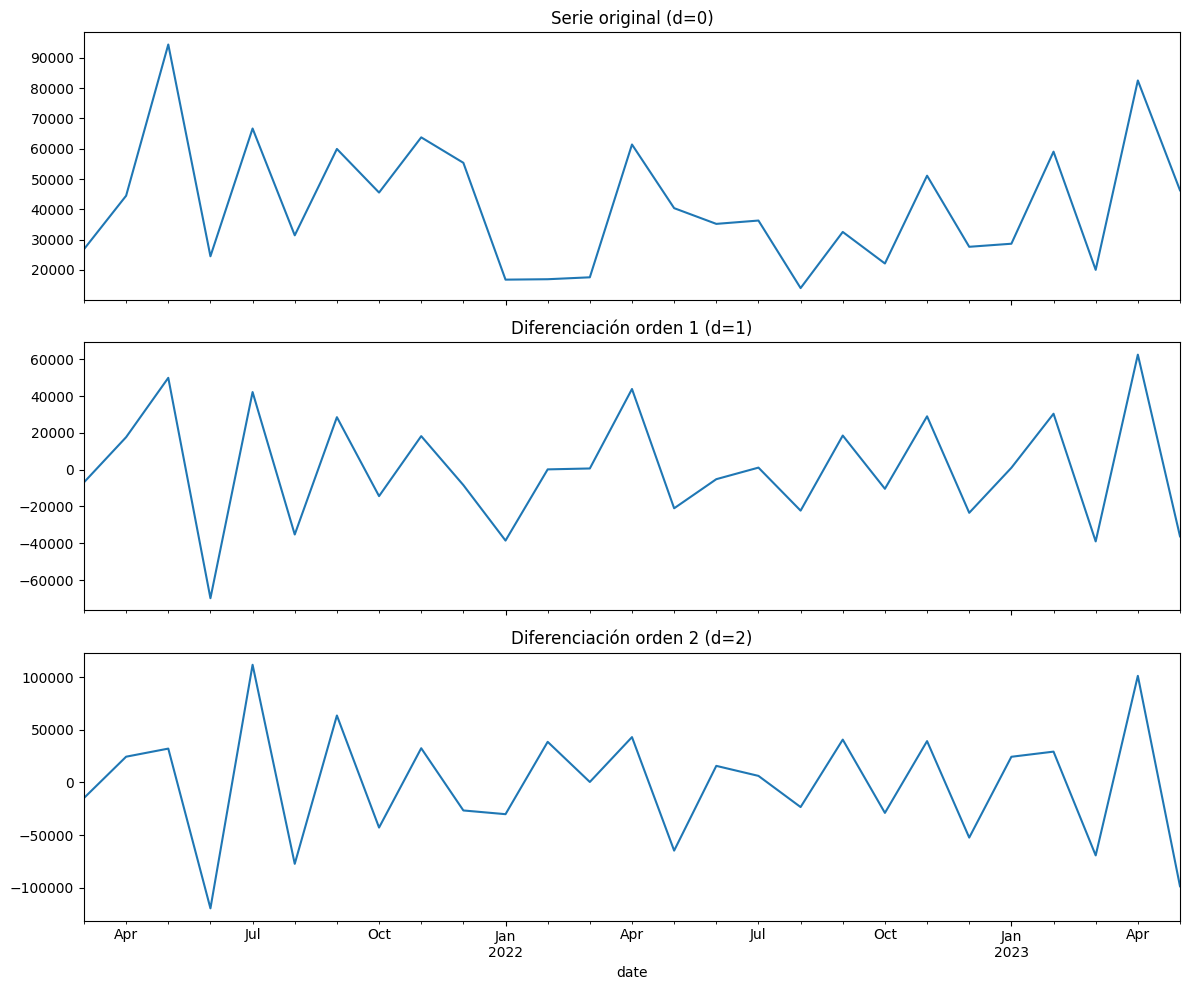

In [4]:
# Convertimos y_train a pd.Series para los análisis (usamos TRAIN)
if "date" in train_data.columns:
    train_index = pd.to_datetime(train_data["date"])
else:
    train_index = None

y_train_series = pd.Series(
    y_train,
    index=train_index,
    name="volume.sales (train)",
)

# ============================================================
# PASO 1: Determinar d (diferenciación regular) usando TRAIN
# ============================================================
print("PASO 1: DETERMINACIÓN DE d (diferenciación regular) [TRAIN]")
print("=" * 60)
results_d = sa.ADF_KPSS_test(y_train_series, series_name="y_train")


PASO 2: DETERMINACIÓN DE D (diferenciación estacional) [TRAIN]
ANÁLISIS DE ESTACIONARIEDAD ESTACIONAL: y_train (m=12)

📊 Test estacionariedad serie ORIGINAL (D=0)
--------------------------------------------------
ADF Statistic: -5.8091, p-value: 0.0000
KPSS Statistic: 0.1112, p-value: 0.1000
   → ADF: Estacionaria ✓
   → KPSS: Estacionaria ✓

📊 Test estacionariedad serie con DIFERENCIACIÓN ESTACIONAL (D=1, lag=12)
--------------------------------------------------
ADF Statistic: -3.5998, p-value: 0.0058
KPSS Statistic: 0.3907, p-value: 0.0811
   → ADF: Estacionaria ✓
   → KPSS: Estacionaria ✓

📊 Análisis ACF para detectar patrón estacional (lags múltiplos de 12)
--------------------------------------------------
Autocorrelaciones en lags estacionales:
   Lag 12: ACF = 0.1804 (no significativo ✓)
   Lag 24: ACF = 0.0676 (no significativo ✓)

RECOMENDACIÓN PARA D:
   → D=0 (no se detecta patrón estacional fuerte)


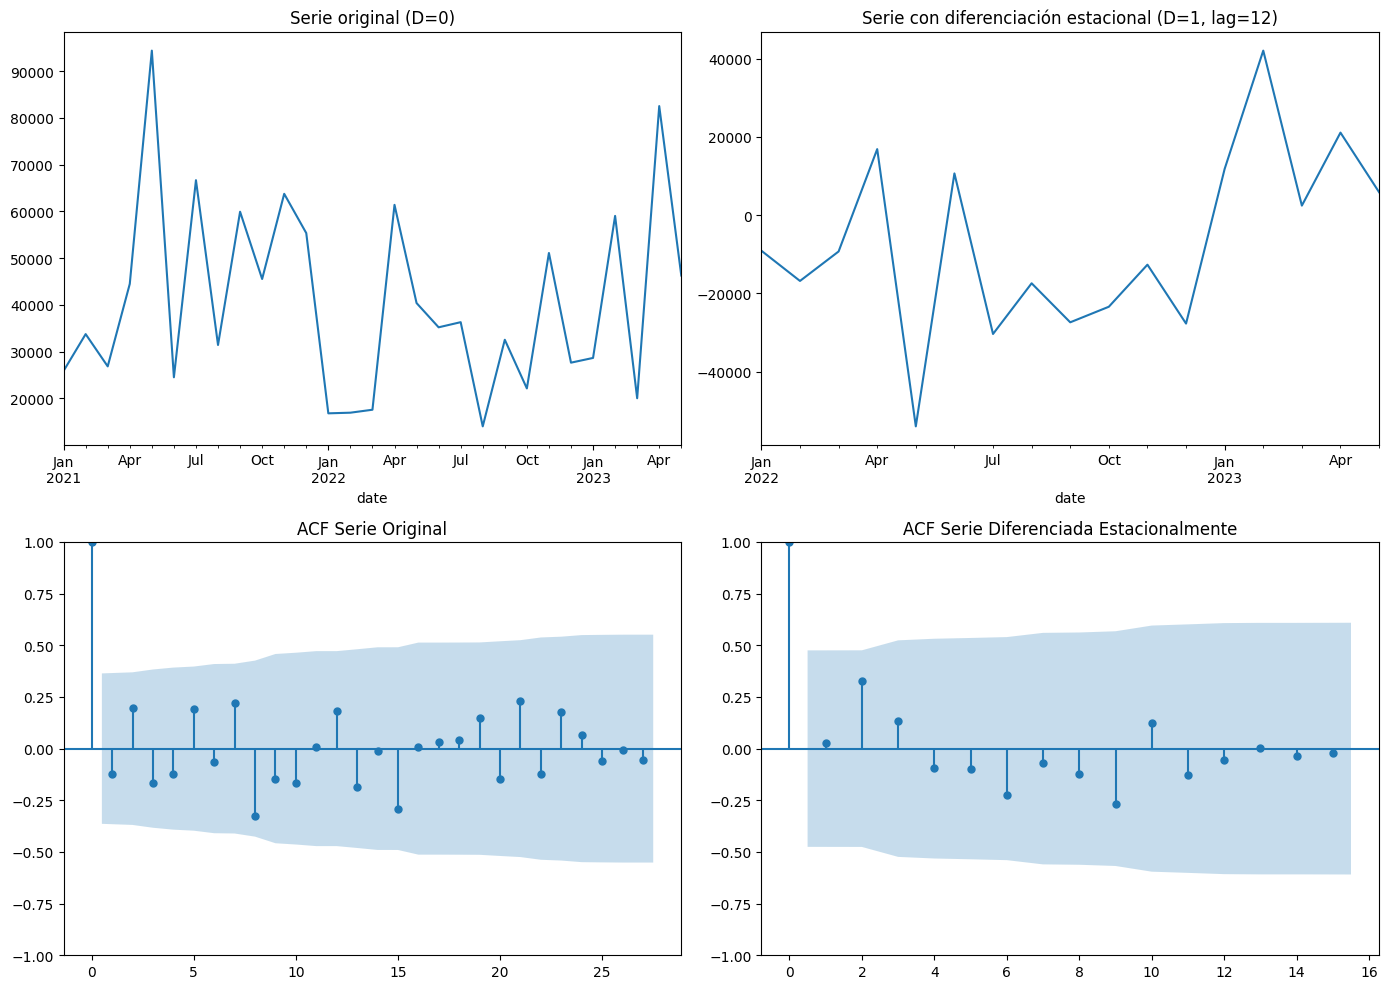

In [5]:
# ============================================================
# PASO 2: Determinar D (diferenciación estacional) usando TRAIN
# ============================================================
print("\nPASO 2: DETERMINACIÓN DE D (diferenciación estacional) [TRAIN]")
print("=" * 60)
results_D = sa.seasonal_stationarity_test(y_train_series, m=12, series_name="y_train")

In [6]:
# ============================================================
# RESUMEN DE RECOMENDACIONES
# ============================================================
print("\n" + "=" * 70)
print("RESUMEN: PARÁMETROS RECOMENDADOS PARA SARIMA")
print("=" * 70)

recommended_d = results_d.get('recommended_d', 0)
recommended_D = results_D.get('recommended_D', 0)

print(f"\n  d (diferenciación regular):   {recommended_d}")
print(f"  D (diferenciación estacional): {recommended_D}")
print(f"  m (periodicidad):             12 (datos mensuales)")

print("\n" + "-" * 70)
print("INTERPRETACIÓN:")
print("-" * 70)

if recommended_d == 0:
    print("  → d=0: La serie YA es estacionaria en media.")
    print("         No requiere diferenciación regular.")
elif recommended_d == 1:
    print("  → d=1: La serie necesita UNA diferenciación regular para ser estacionaria.")
else:
    print("  → d=2: La serie necesita DOS diferenciaciones regulares.")

if recommended_D == 0:
    print("  → D=0: No se detecta patrón estacional fuerte.")
else:
    print("  → D=1: Se detecta patrón estacional. Se recomienda diferenciación estacional.")

print("\n" + "=" * 70)


RESUMEN: PARÁMETROS RECOMENDADOS PARA SARIMA

  d (diferenciación regular):   0
  D (diferenciación estacional): 0
  m (periodicidad):             12 (datos mensuales)

----------------------------------------------------------------------
INTERPRETACIÓN:
----------------------------------------------------------------------
  → d=0: La serie YA es estacionaria en media.
         No requiere diferenciación regular.
  → D=0: No se detecta patrón estacional fuerte.



Longitud TRAIN: 29 observaciones
Longitud TRAIN dif. estacional: 17 observaciones
Lags ACF: 27 (train), 15 (train dif. estacional)
Lags PACF: 13 (train), 7 (train dif. estacional)


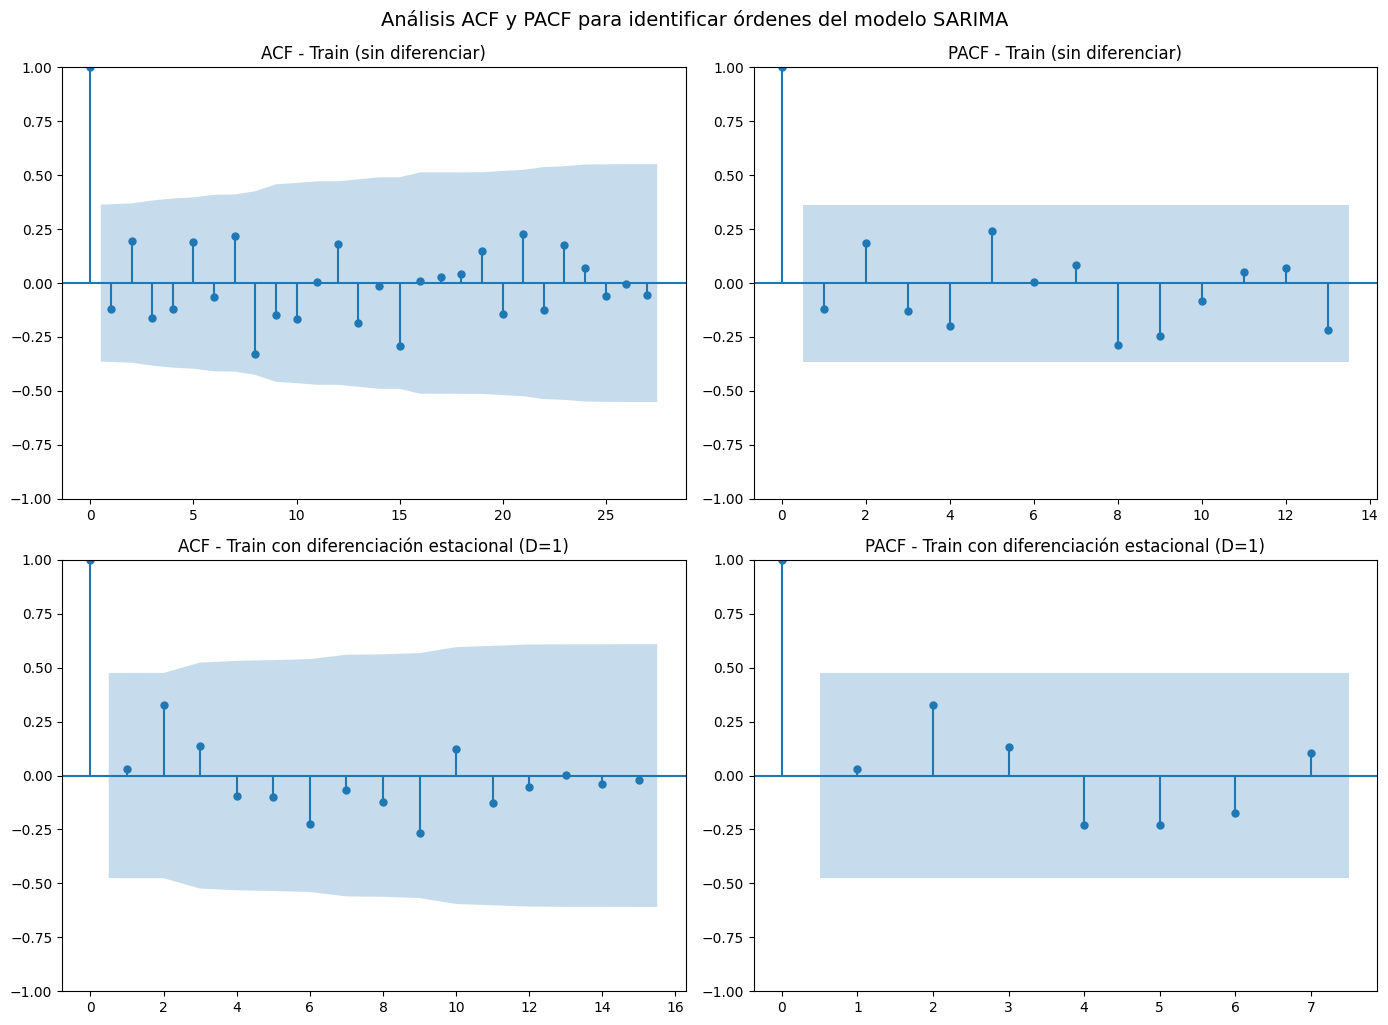


INTERPRETACIÓN DE ACF/PACF:
------------------------------------------------------------
• ACF con decaimiento exponencial + PACF corta en lag k → AR(p=k)
• ACF corta en lag k + PACF con decaimiento → MA(q=k)
• Picos en lags 12, 24, 36... indican componente estacional
• Usar auto_arima para búsqueda automática de p, q, P, Q


In [7]:
# ============================================================
# VISUALIZACIÓN ACF y PACF para determinar p, q, P, Q (TRAIN)
# ============================================================
# El ACF y PACF nos ayudan a identificar los órdenes AR (p, P) y MA (q, Q)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

y_seasonal_diff = y_train_series.diff(12).dropna()

# ACF puede ir hasta len-2; PACF hasta < 50% de la muestra
max_lags_acf = min(40, len(y_train_series) - 2)
max_lags_pacf = min(40, len(y_train_series) // 2 - 1)
max_lags_acf_diff = min(40, len(y_seasonal_diff) - 2)
max_lags_pacf_diff = min(40, len(y_seasonal_diff) // 2 - 1)

print(f"Longitud TRAIN: {len(y_train_series)} observaciones")
print(f"Longitud TRAIN dif. estacional: {len(y_seasonal_diff)} observaciones")
print(f"Lags ACF: {max_lags_acf} (train), {max_lags_acf_diff} (train dif. estacional)")
print(f"Lags PACF: {max_lags_pacf} (train), {max_lags_pacf_diff} (train dif. estacional)")

plot_acf(y_train_series, lags=max_lags_acf, ax=axes[0, 0], title="ACF - Train (sin diferenciar)")
plot_pacf(y_train_series, lags=max_lags_pacf, ax=axes[0, 1], title="PACF - Train (sin diferenciar)")

plot_acf(y_seasonal_diff, lags=max_lags_acf_diff, ax=axes[1, 0], title="ACF - Train con diferenciación estacional (D=1)")
plot_pacf(y_seasonal_diff, lags=max_lags_pacf_diff, ax=axes[1, 1], title="PACF - Train con diferenciación estacional (D=1)")

plt.tight_layout()
plt.suptitle("Análisis ACF y PACF para identificar órdenes del modelo SARIMA", y=1.02, fontsize=14)
plt.show()

print("\nINTERPRETACIÓN DE ACF/PACF:")
print("-" * 60)
print("• ACF con decaimiento exponencial + PACF corta en lag k → AR(p=k)")
print("• ACF corta en lag k + PACF con decaimiento → MA(q=k)")
print("• Picos en lags 12, 24, 36... indican componente estacional")
print("• Usar auto_arima para búsqueda automática de p, q, P, Q")

In [8]:
# ============================================================
# AJUSTE DEL MODELO SARIMA CON AUTO_ARIMA (TRAIN)
# ============================================================
# Ajustamos el modelo SOLO con train. Test se usará para evaluación de predicción.
# Forzamos d=1, D=1 para capturar tendencia y estacionalidad (evitar predicción horizontal).
# start_p=1 evita el modelo nulo (0,0,0)(0,0,0) que predice solo la media.

print("Ajustando modelo SARIMA (TRAIN) con d=1, D=1, m=12 (forzado para capturar tendencia y estacionalidad)")
print("=" * 60)

autoarima_model = auto_arima(
    y=y_train,
    start_p=1,
    d=1,
    start_q=0,
    max_p=3,
    max_q=3,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,
    n_fits=100,
    information_criterion="aic",
)

print("\n" + "=" * 60)
print("MODELO SELECCIONADO:")
print("=" * 60)
print(autoarima_model.summary())

Ajustando modelo SARIMA (TRAIN) con d=1, D=1, m=12 (forzado para capturar tendencia y estacionalidad)
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=375.517, Time=0.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=380.310, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=369.348, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=371.209, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=371.080, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=371.103, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=369.786, Time=0.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=373.080, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=375.105, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=371.084, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=370.131, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=370.694, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=372.080, Time=0.11 s


Nota: 0 observaciones iniciales sin predicción (debido a diferenciación)

BONDAD DE AJUSTE (TRAIN)
Observaciones evaluadas: 29 de 29
RMSE (train): 24089.491
MAE  (train): 17269.317
MAPE (train): 56.64%


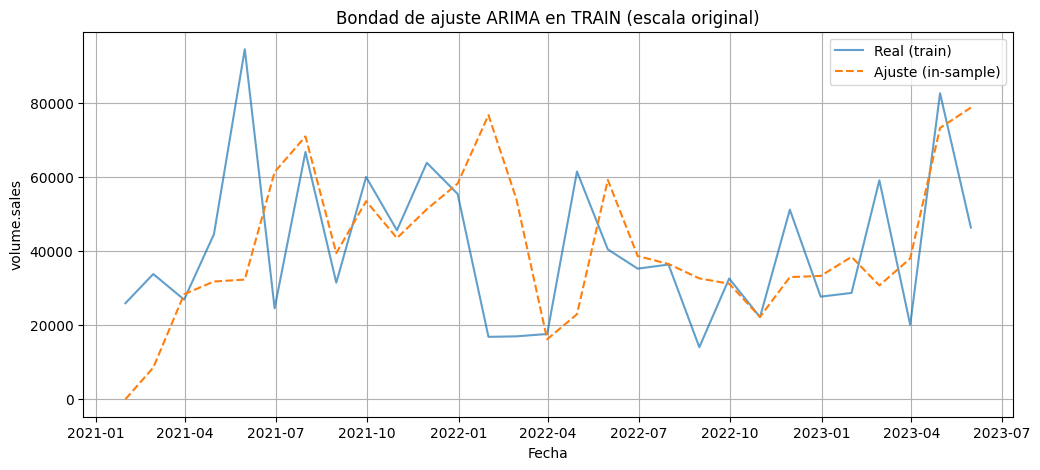


----------------- Residuals White Noise Test -----------------
[Heteroscedasticity Test] ARCH p-value: 0.48759266909338217 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 0.7015959362928947 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 0.6493003674128297 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
     lb_stat  lb_pvalue
10  7.92467   0.636195 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.9392974706390946 -- range(2.0)
--------------------------------------------------------------------


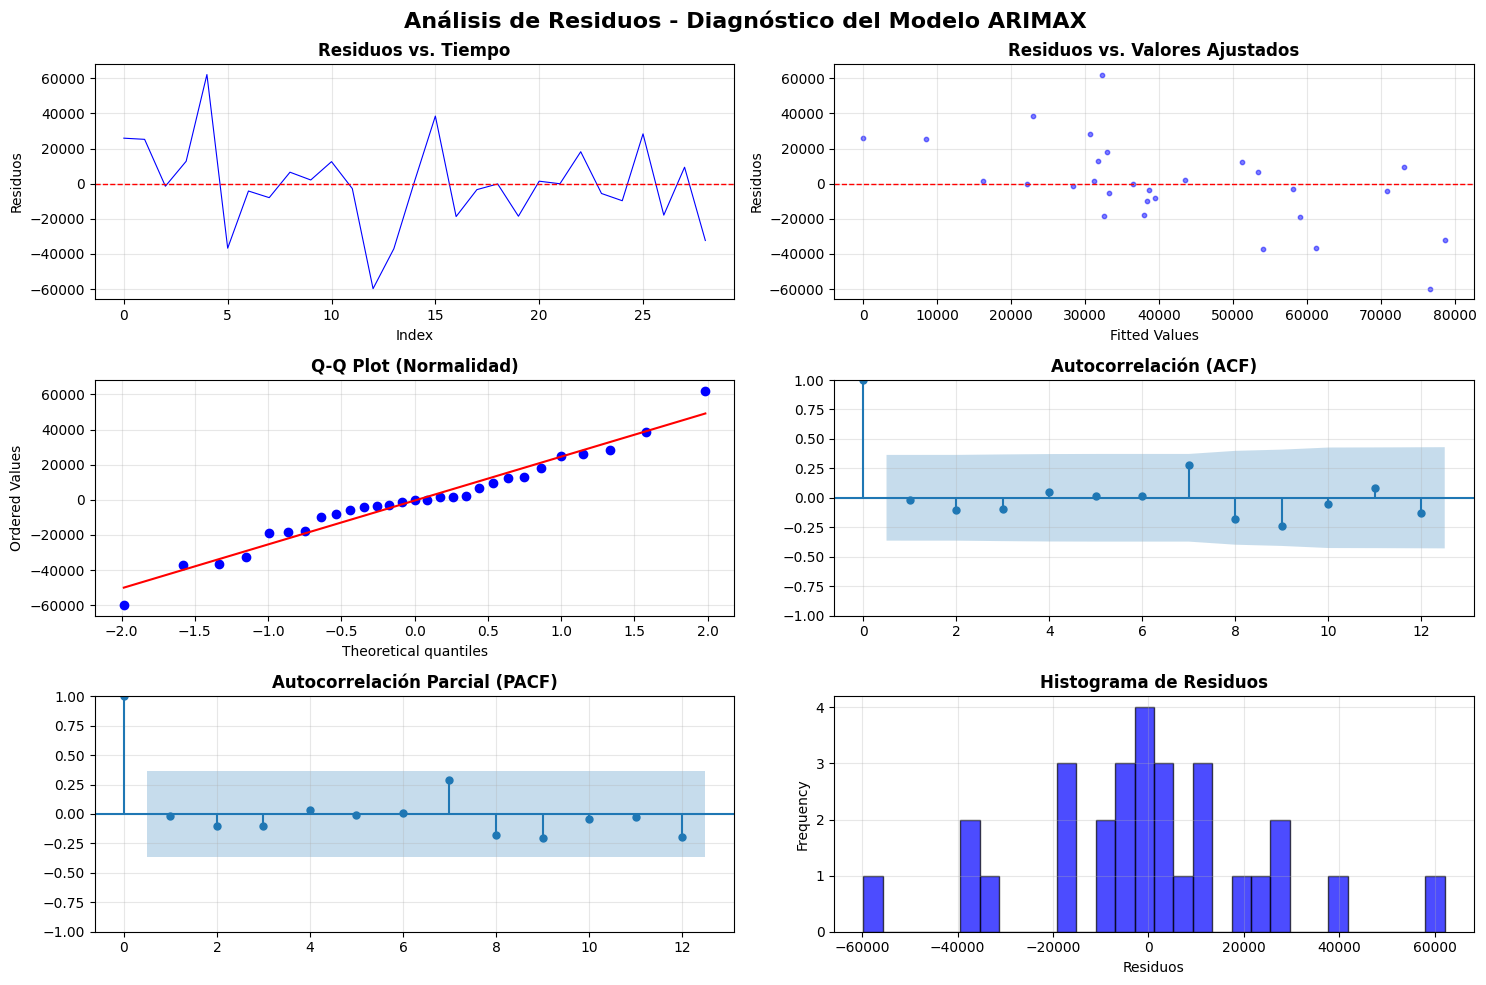

In [9]:
# ============================================================
# BONDAD DE AJUSTE (TRAIN) + DIAGNÓSTICO DE RESIDUOS
# ============================================================

# --- In-sample fit (sobre train) ---
yhat_train = autoarima_model.predict_in_sample()

y_train_true = train_data["volume.sales"].values

# IMPORTANTE: Excluir NaN de las predicciones in-sample
# Las primeras d + D*m observaciones no tienen predicción válida debido a la diferenciación
valid_mask = ~np.isnan(yhat_train)
n_lost = (~valid_mask).sum()
print(f"\nNota: {n_lost} observaciones iniciales sin predicción (debido a diferenciación)")

y_train_valid = y_train_true[valid_mask]
yhat_train_valid = yhat_train[valid_mask]

# Métricas train (solo sobre observaciones válidas)
rmse_train = np.sqrt(mean_squared_error(y_train_valid, yhat_train_valid))
mae_train = mean_absolute_error(y_train_valid, yhat_train_valid)

# MAPE (evitar división por 0)
mask_mape = y_train_valid != 0
mape_train = np.mean(np.abs((y_train_valid[mask_mape] - yhat_train_valid[mask_mape]) / y_train_valid[mask_mape])) * 100

print("\n" + "=" * 70)
print("BONDAD DE AJUSTE (TRAIN)")
print("=" * 70)
print(f"Observaciones evaluadas: {len(y_train_valid)} de {len(y_train_true)}")
print(f"RMSE (train): {rmse_train:.3f}")
print(f"MAE  (train): {mae_train:.3f}")
print(f"MAPE (train): {mape_train:.2f}%")

# Gráfico ajuste train
if "date" in train_data.columns:
    x_train = pd.to_datetime(train_data["date"])
else:
    x_train = np.arange(len(train_data))

plt.figure(figsize=(12, 5))
plt.plot(x_train, y_train_true, label="Real (train)", alpha=0.7)
plt.plot(x_train[valid_mask], yhat_train_valid, label="Ajuste (in-sample)", linestyle="--")
plt.title("Bondad de ajuste ARIMA en TRAIN (escala original)")
plt.xlabel("Fecha" if "date" in train_data.columns else "t")
plt.ylabel("volume.sales")
plt.legend()
plt.grid(True)
plt.show()

# --- Residuos ---
residuals = autoarima_model.resid()
print("\n----------------- Residuals White Noise Test -----------------")
sa.residual_white_noise_test(residuals)
print("--------------------------------------------------------------------")

# Diagnóstico de residuos
residuals_fit = autoarima_model.arima_res_.resid
fitted_values_fit = autoarima_model.arima_res_.fittedvalues
sa.analysis_residuals(residuals_fit, fitted_values_fit)



PREDICCIÓN EN TEST (h=7)
RMSE (test): 21873.528
MAE  (test): 16054.356
MAPE (test): 26.77%


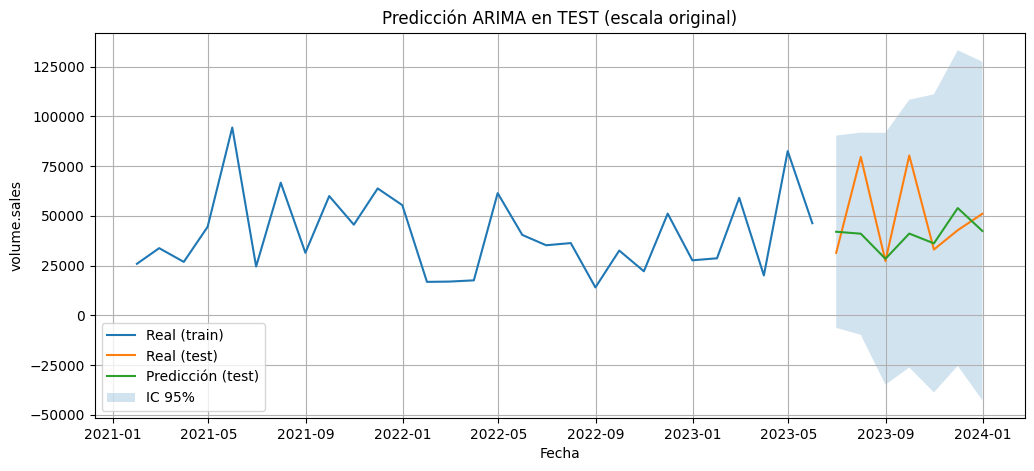


RESUMEN DE MÉTRICAS


,Train,Test
RMSE,24089.490811,21873.527795
MAE,17269.317427,16054.355777
MAPE_%,56.643523,26.772933


In [10]:
# ============================================================
# PREDICCIÓN Y EVALUACIÓN (TEST)
# ============================================================

h = len(test_data)
print("\n" + "=" * 70)
print(f"PREDICCIÓN EN TEST (h={h})")
print("=" * 70)

# Predicción en escala original
pred_test, conf_int = autoarima_model.predict(
    n_periods=h,
    return_conf_int=True,
    alpha=0.05,
)

# Las predicciones ya están en escala original (sin transformación)
conf_lower = conf_int[:, 0]
conf_upper = conf_int[:, 1]

# Por seguridad, garantizar que lower <= upper
conf_lower, conf_upper = np.minimum(conf_lower, conf_upper), np.maximum(conf_lower, conf_upper)

y_test_true = test_data["volume.sales"].values

rmse_test = np.sqrt(mean_squared_error(y_test_true, pred_test))
mae_test = mean_absolute_error(y_test_true, pred_test)
mask = y_test_true != 0
mape_test = np.mean(np.abs((y_test_true[mask] - pred_test[mask]) / y_test_true[mask])) * 100

print(f"RMSE (test): {rmse_test:.3f}")
print(f"MAE  (test): {mae_test:.3f}")
print(f"MAPE (test): {mape_test:.2f}%")

# Gráfico predicción test
if "date" in test_data.columns:
    x_test = pd.to_datetime(test_data["date"])
else:
    x_test = np.arange(len(train_data), len(train_data) + len(test_data))

plt.figure(figsize=(12, 5))
plt.plot(x_train, y_train_true, label="Real (train)")
plt.plot(x_test, y_test_true, label="Real (test)")
plt.plot(x_test, pred_test, label="Predicción (test)")
plt.fill_between(x_test, conf_lower, conf_upper, alpha=0.2, label="IC 95%")
plt.title("Predicción ARIMA en TEST (escala original)")
plt.xlabel("Fecha" if "date" in test_data.columns else "t")
plt.ylabel("volume.sales")
plt.legend()
plt.grid(True)
plt.show()

# Tabla resumen
summary_metrics = pd.DataFrame(
    {
        "Train": {"RMSE": rmse_train, "MAE": mae_train, "MAPE_%": mape_train},
        "Test": {"RMSE": rmse_test, "MAE": mae_test, "MAPE_%": mape_test},
    }
)

print("\n" + "=" * 70)
print("RESUMEN DE MÉTRICAS")
print("=" * 70)
display(summary_metrics)
